In [1]:
import numpy as np

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

from radmc3dPy.image import *    # Make sure that the shell variable PYTHONPATH points to the RADMC-3D python directory
from radmc3dPy.analyze import *  # Make sure that the shell variable PYTHONPATH points to the RADMC-3D python directory
from radmc3dPy.natconst import *

import os

In [2]:
def logistic(a, r, r0, dr):
    return np.radians(a/(1+np.exp((r-r0)/(0.1*dr))))

In [3]:
def grid_refine_inner_edge(x_orig,nlev,nspan):
    x     = x_orig.copy()
    rev   = x[0]>x[1]
    for ilev in range(nlev):
        x_new = 0.5 * ( x[1:nspan+1] + x[:nspan] )
        x_ref = np.hstack((x,x_new))
        x_ref.sort()
        x     = x_ref
        if rev:
            x = x[::-1]
    return x

In [4]:
def warped_coordinate_transformation(theta_3d,phi_3d,r_1d,lunit_1d):
    #assert theta_3d.shape[0]==len(r_1d), 'Error in coordinate transformation: nr of elements of r_1d array does not match.'
    #assert len(lunit_1d.shape)!=2, 'Error in coordinate transformation: l_1d array must have [nr,2] elements.'
    #assert lunit_1d.shape[0]==len(r_1d), 'Error in coordinate transformation: nr of elements of l_1d array does not match.'
    #assert lunit_1d.shape[1]==3, 'Error in coordinate transformation: l_1d array must have [nr,2] elements.'
    theta_prime_3d = np.zeros_like(theta_3d)
    phi_prime_3d   = np.zeros_like(phi_3d)
    for ir in range(len(r_1d)):
        l = lunit_1d[ir, :] # Gets the tilt and twist angle for given radius
        tilt  = l[0]
        Twist  = l[1]
        #print(np.rad2deg(tilt), 'tilt angle')
        #print(np.rad2deg(Twist), 'Twist angle')
        r     = r_1d[ir] # Get current radius
        #print(r, 'rRRR')
        
        theta = theta_3d[ir,:,:]
        phi   = phi_3d[ir,:,:]
        
        x     = r*np.sin(theta)*np.cos(phi)
        #print(x.shape, 'x shape')
        y     = r*np.sin(theta)*np.sin(phi)
        z     = r*np.cos(theta)
        
        #xt, yt, zt = Rx(x, y, z, tilt)
        #xT, yT, zT = Rz(xt, yt, zt, Twist)
        xT = np.cos(Twist) * x - np.sin(Twist) * (np.cos(tilt) * y - np.sin(tilt) * z)
        yT = np.sin(Twist) * x + np.cos(Twist) * (np.cos(tilt) * y - np.sin(tilt) * z)
        zT = np.sin(tilt) * y + np.cos(tilt) * z
        
        
        #rr    = np.sqrt(xn**2+yn**2+zn**2)
        pp    = get_angle(xT,yT,positive=True)
        #print(pp.shape)
        #print(np.rad2deg(pp), 'pp')
        tt    = get_angle(zT,np.sqrt(xT**2+yT**2))
        #print(np.rad2deg(tt), 'tt')
        
        theta_prime_3d[ir,:,:] = tt
        phi_prime_3d[ir,:,:]   = pp
    return theta_prime_3d,phi_prime_3d

In [5]:
def get_angle(x,y,positive=False):
    if np.isscalar(x):
        xx   = np.array([x])
        yy   = np.array([y])
    else:
        xx   = np.array(x)
        yy   = np.array(y)
    xx  += 1e-90*np.pi
    ang  = np.arctan(yy/xx)
    ang[xx<0] -= np.pi
    if positive:
        ang[ang<0] += 2*np.pi
    else:
        ang[ang<=-np.pi] += 2*np.pi
    if len(ang)==1:
        ang = ang[0]
    return ang
#
# Simple rotation counterclockwise
#
def rotate(x,y,ang):
    cos = np.cos(ang)
    sin = np.sin(ang)
    xp  = cos*x - sin*y
    yp  = sin*x + cos*y
    return xp,yp

def Rx(x, y, z, ang):
    cos = np.cos(ang)
    sin = np.sin(ang)
    
    xp = x
    yp = cos*y - sin*z
    zp = sin*y + cos*z
    return xp, yp, zp

def Ry(x, y, z, ang):
    cos = np.cos(ang)
    sin = np.sin(ang)
    
    xp = cos*x + sin*z
    yp = y
    zp = -sin*x + cos*z
    return xp, yp, zp

def Rz(x, y, z, ang):
    cos = np.cos(ang)
    sin = np.sin(ang)
    
    xp = cos*x - sin*y
    yp = sin*x + cos*y
    zp = z
    return xp, yp, zp

In [6]:
#
# Some natural constants
#
au  = 1.49598e13     # Astronomical Unit       [cm]
pc  = 3.08572e18     # Parsec                  [cm]
ms  = 1.98892e33     # Solar mass              [g]
ts  = 5.78e3         # Solar temperature       [K]
ls  = 3.8525e33      # Solar luminosity        [erg/s]
rs  = 6.96e10        # Solar radius            [cm]
GG  = 6.67408e-08    # Gravitational constant  [cm^3/g/s^2]
mp  = 1.6726e-24     # Mass of proton          [g]
#
# Monte Carlo parameters
#
nphot_therm = 1000000
nphot_scat  = 1000000
#
# Grid parameters
#
nr       = 100
ntheta   = 64
nphi     = 128
rin      = 1.0*au
rout     = 80*au
#thetaup  = np.pi*0.5 - 0.7e0
thetaup  = 0.1       # Theta grid starting point (0=pole, but singular, so choose >0)
nlev_rin = 8
nspan_rin= 3
#
# Disk parameters
#
sigmag0  = 1e1               # Sigma gas at 1 AU
dtg      = 0.01              # Dust-to-gas ratio
plsig    = -1.0e0            # Powerlaw of the surface density
hr0      = 0.05              # H_p/r at 1 AU
plh      = 0.1               # Powerlaw of flaring
#
# Star parameters
#
mstar    = 2.4*ms
rstar    = 2.4*rs
tstar    = 1e4
pstar    = np.array([0.,0.,0.])


In [31]:
#
# Make the coordinates
#
nr=100
ri       = np.logspace(np.log10(rin),np.log10(rout),nr+1)
ri       = grid_refine_inner_edge(ri,nlev_rin,nspan_rin)   # Refinement at inner edge
thetai   = np.linspace(thetaup,np.pi-thetaup,ntheta+1)
phii     = np.linspace(0.e0,np.pi*2.e0,nphi+1)
rc       = 0.5 * ( ri[:-1] + ri[1:] )
thetac   = 0.5 * ( thetai[:-1] + thetai[1:] )
phic     = 0.5 * ( phii[:-1] + phii[1:] )
nr       = len(rc)     # Recompute nr, because of refinement at inner edge
#
# Make the grid
#
qq       = np.meshgrid(rc,thetac,phic,indexing='ij')
rr       = qq[0]
tt0      = qq[1]
pp0      = qq[2]
#print(tt0.shape,'tt0 shape')
#print(pp0.shape, 'pp0 shape')

#
# Warp the coordinates
#
incw = 60.
PAw = 45.


tiltTwist= np.zeros((nr,2))
incw     = np.pi/2 - logistic(incw, rc, 10*au, 5*au) ### Specify AU, correction for the angle in sphericals
PAw      = logistic(PAw, rc, 10*au, 5*au)
tiltTwist[:,0]  = incw
tiltTwist[:,1]  = PAw
tt,pp    = warped_coordinate_transformation(tt0, pp0, rc, tiltTwist)
zr       = np.pi/2.e0 - tt #

#
# Transformation to cartesian
# ### Be care when rerruning this cell!!!
#xx = rr*np.sin(tt)*np.cos(pp)
#yy = rr*np.sin(tt)*np.sin(pp)
#zz = rr*np.cos(tt)

In [32]:
#
# Make the dust density model
#
sigmag   = sigmag0 * (rr/au)**plsig
hhr      = hr0 * (rr/au)**plh
hh       = hhr * rr
rhog     = ( sigmag / (np.sqrt(2.e0*np.pi)*hh) ) * np.exp(-(zr**2/hhr**2)/2.e0)
rhod     = dtg * rhog
#
# Make the velocity model
#
vr       = np.zeros_like(rr)
vtheta   = np.zeros_like(rr)
vphi     = np.sqrt(GG*mstar/rr)
#vturb    = 0.1*vphi
vturb    = 0.001*vphi
#
# Write the wavelength_micron.inp file
#
lam1     = 0.1e0
lam2     = 7.0e0
lam3     = 25.0e0
lam4     = 1.0e4
n12      = 20
n23      = 100
n34      = 30
lam12    = np.logspace(np.log10(lam1),np.log10(lam2),n12,endpoint=False)
lam23    = np.logspace(np.log10(lam2),np.log10(lam3),n23,endpoint=False)
lam34    = np.logspace(np.log10(lam3),np.log10(lam4),n34,endpoint=True)
lam      = np.concatenate([lam12,lam23,lam34])
nlam     = lam.size
#
# Write the wavelength file
#
with open('wavelength_micron.inp','w+') as f:
    f.write('%d\n'%(nlam))
    for value in lam:
        f.write('%13.6e\n'%(value))
#
#
# Write the stars.inp file
#
with open('stars.inp','w+') as f:
    f.write('2\n')
    f.write('1 %d\n\n'%(nlam))
    f.write('%13.6e %13.6e %13.6e %13.6e %13.6e\n\n'%(rstar,mstar,pstar[0],pstar[1],pstar[2]))
    for value in lam:
        f.write('%13.6e\n'%(value))
    f.write('\n%13.6e\n'%(-tstar))
#
# Write the grid file
#
with open('amr_grid.inp','w+') as f:
    f.write('1\n')                       # iformat
    f.write('0\n')                       # AMR grid style  (0=regular grid, no AMR)
    f.write('100\n')                     # Coordinate system: spherical
    f.write('0\n')                       # gridinfo
    f.write('1 1 1\n')                   # Include r,theta coordinates
    f.write('%d %d %d\n'%(nr,ntheta,nphi))  # Size of grid
    for value in ri:
        f.write('%13.6e\n'%(value))      # X coordinates (cell walls)
    for value in thetai:
        f.write('%13.6e\n'%(value))      # Y coordinates (cell walls)
    for value in phii:
        f.write('%13.6e\n'%(value))      # Z coordinates (cell walls)
#
# Write the density file
#
with open('dust_density.inp','w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n'%(nr*ntheta*nphi))     # Nr of cells
    f.write('1\n')                       # Nr of dust species
    data = rhod.ravel(order='F')         # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')
#
# Dust opacity control file
#
with open('dustopac.inp','w+') as f:
    f.write('2               Format number of this file\n')
    f.write('1               Nr of dust species\n')
    f.write('============================================================================\n')
    f.write('1               Way in which this dust species is read\n')
    f.write('0               0=Thermal grain\n')
    f.write('silicate        Extension of name of dustkappa_***.inp file\n')
    f.write('----------------------------------------------------------------------------\n')
#
# Write the molecule number density file. 
#
abunco = 1e-4
factco = abunco/(2.3*mp)
nco    = rhog*factco
with open('numberdens_co.inp','w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n'%(nr*ntheta*nphi))     # Nr of cells
    data = nco.ravel(order='F')          # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')
#
# Write the gas velocity field
#
with open('gas_velocity.inp','w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n'%(nr*ntheta*nphi))     # Nr of cells
    for iphi in range(nphi):
        for itheta in range(ntheta):
            for ir in range(nr):
                f.write('%13.6e %13.6e %13.6e\n'%(vr[ir,itheta,iphi],vtheta[ir,itheta,iphi],vphi[ir,itheta,iphi]))
#
# Write the microturbulence file
#
with open('microturbulence.inp','w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n'%(nr*ntheta*nphi))     # Nr of cells
    data = vturb.ravel(order='F')        # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')
#
# Write the lines.inp control file
#
with open('lines.inp','w') as f:
    f.write('1\n')
    f.write('1\n')
    f.write('co    leiden    0    0\n')
#
# Write the radmc3d.inp control file
#
with open('radmc3d.inp','w+') as f:
    f.write('nphot = %d\n'%(nphot_therm))
    f.write('nphot_scat = %d\n'%(nphot_scat))
    f.write('scattering_mode_max = 1\n')
    f.write('iranfreqmode = 1\n')
    f.write('tgas_eq_tdust = 1\n')

In [33]:
os.system('radmc3d mctherm setthreads 4')

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2020 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
                     the RADMC-3D forum:                         
            http://radmc3d.ita.uni-heidelberg.de/phpbb/          
                                                                 
       

 Thread:           2 Photon nr:                99000
 Thread:           1 Photon nr:               100000
 Thread:           2 Photon nr:               101000
 Thread:           1 Photon nr:               102000
 Thread:           2 Photon nr:               103000
 Thread:           3 Photon nr:               104000
 Thread:           2 Photon nr:               105000
 Thread:           0 Photon nr:               106000
 Thread:           1 Photon nr:               107000
 Thread:           3 Photon nr:               108000
 Thread:           2 Photon nr:               109000
 Thread:           1 Photon nr:               110000
 Thread:           3 Photon nr:               111000
 Thread:           1 Photon nr:               112000
 Thread:           1 Photon nr:               113000
 Thread:           0 Photon nr:               114000
 Thread:           0 Photon nr:               115000
 Thread:           1 Photon nr:               116000
 Thread:           1 Photon nr:               

 Thread:           1 Photon nr:               254000
 Thread:           1 Photon nr:               255000
 Thread:           0 Photon nr:               256000
 Thread:           1 Photon nr:               257000
 Thread:           2 Photon nr:               258000
 Thread:           1 Photon nr:               259000
 Thread:           1 Photon nr:               260000
 Thread:           2 Photon nr:               261000
 Thread:           2 Photon nr:               262000
 Thread:           0 Photon nr:               263000
 Thread:           0 Photon nr:               264000
 Thread:           0 Photon nr:               265000
 Thread:           1 Photon nr:               266000
 Thread:           1 Photon nr:               267000
 Thread:           1 Photon nr:               268000
 Thread:           2 Photon nr:               269000
 Thread:           0 Photon nr:               270000
 Thread:           3 Photon nr:               271000
 Thread:           1 Photon nr:               

 Thread:           3 Photon nr:               410000
 Thread:           3 Photon nr:               411000
 Thread:           1 Photon nr:               412000
 Thread:           2 Photon nr:               413000
 Thread:           2 Photon nr:               414000
 Thread:           0 Photon nr:               415000
 Thread:           2 Photon nr:               416000
 Thread:           2 Photon nr:               417000
 Thread:           3 Photon nr:               418000
 Thread:           1 Photon nr:               419000
 Thread:           1 Photon nr:               420000
 Thread:           3 Photon nr:               421000
 Thread:           2 Photon nr:               422000
 Thread:           2 Photon nr:               423000
 Thread:           0 Photon nr:               424000
 Thread:           1 Photon nr:               425000
 Thread:           2 Photon nr:               426000
 Thread:           2 Photon nr:               427000
 Thread:           2 Photon nr:               

 Thread:           3 Photon nr:               566000
 Thread:           3 Photon nr:               567000
 Thread:           3 Photon nr:               568000
 Thread:           0 Photon nr:               569000
 Thread:           0 Photon nr:               570000
 Thread:           1 Photon nr:               571000
 Thread:           0 Photon nr:               572000
 Thread:           2 Photon nr:               573000
 Thread:           0 Photon nr:               574000
 Thread:           3 Photon nr:               575000
 Thread:           0 Photon nr:               576000
 Thread:           2 Photon nr:               577000
 Thread:           3 Photon nr:               578000
 Thread:           2 Photon nr:               579000
 Thread:           2 Photon nr:               580000
 Thread:           2 Photon nr:               581000
 Thread:           3 Photon nr:               582000
 Thread:           0 Photon nr:               583000
 Thread:           0 Photon nr:               

 Thread:           3 Photon nr:               723000
 Thread:           2 Photon nr:               724000
 Thread:           1 Photon nr:               725000
 Thread:           2 Photon nr:               726000
 Thread:           0 Photon nr:               727000
 Thread:           1 Photon nr:               728000
 Thread:           3 Photon nr:               729000
 Thread:           2 Photon nr:               730000
 Thread:           3 Photon nr:               731000
 Thread:           3 Photon nr:               732000
 Thread:           2 Photon nr:               733000
 Thread:           1 Photon nr:               734000
 Thread:           2 Photon nr:               735000
 Thread:           0 Photon nr:               736000
 Thread:           0 Photon nr:               737000
 Thread:           3 Photon nr:               738000
 Thread:           3 Photon nr:               739000
 Thread:           0 Photon nr:               740000
 Thread:           3 Photon nr:               

 Thread:           2 Photon nr:               880000
 Thread:           1 Photon nr:               881000
 Thread:           2 Photon nr:               882000
 Thread:           2 Photon nr:               883000
 Thread:           0 Photon nr:               884000
 Thread:           1 Photon nr:               885000
 Thread:           1 Photon nr:               886000
 Thread:           3 Photon nr:               887000
 Thread:           0 Photon nr:               888000
 Thread:           2 Photon nr:               889000
 Thread:           0 Photon nr:               890000
 Thread:           3 Photon nr:               891000
 Thread:           3 Photon nr:               892000
 Thread:           1 Photon nr:               893000
 Thread:           1 Photon nr:               894000
 Thread:           0 Photon nr:               895000
 Thread:           1 Photon nr:               896000
 Thread:           3 Photon nr:               897000
 Thread:           3 Photon nr:               

0

# Diagnostic plots

In [34]:
from radmc3dPy import *
import matplotlib.pylab as plb

In [35]:
data = analyze.readData(ddens=True)

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp


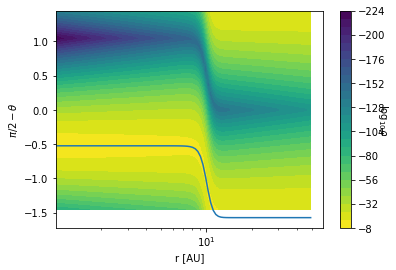

In [36]:
c = plb.contourf(data.grid.x/natconst.au, np.pi/2.-data.grid.y, np.log10(data.rhodust[:,:,32,0].T), 30)

plb.xlabel('r [AU]')
plb.ylabel(r'$\pi/2-\theta$')
plb.xscale('log')
plt.plot(rc/au, -incw)

cb = plb.colorbar(c)
cb.set_label(r'$\log_{10}{\rho}$', rotation=270.)



# Dust images

Executing RADMC-3D Command:
radmc3d image npix 400 incl 45.0 sizeau 50 lambda 1300.0 phi 90.0 pointau 0.0  0.0  0.0 fluxcons setthreads 4
  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2020 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
                     the RADMC-3D forum:                         
 

 Thread:           2 Photon nr:                82000
 Thread:           2 Photon nr:                83000
 Thread:           0 Photon nr:                84000
 Thread:           1 Photon nr:                85000
 Thread:           1 Photon nr:                86000
 Thread:           3 Photon nr:                87000
 Thread:           2 Photon nr:                88000
 Thread:           2 Photon nr:                89000
 Thread:           3 Photon nr:                90000
 Thread:           0 Photon nr:                91000
 Thread:           2 Photon nr:                92000
 Thread:           1 Photon nr:                93000
 Thread:           1 Photon nr:                94000
 Thread:           1 Photon nr:                95000
 Thread:           1 Photon nr:                96000
 Thread:           2 Photon nr:                97000
 Thread:           3 Photon nr:                98000
 Thread:           2 Photon nr:                99000
 Thread:           2 Photon nr:               

 Thread:           3 Photon nr:               239000
 Thread:           1 Photon nr:               240000
 Thread:           3 Photon nr:               241000
 Thread:           2 Photon nr:               242000
 Thread:           1 Photon nr:               243000
 Thread:           1 Photon nr:               244000
 Thread:           2 Photon nr:               245000
 Thread:           3 Photon nr:               246000
 Thread:           1 Photon nr:               247000
 Thread:           0 Photon nr:               248000
 Thread:           1 Photon nr:               249000
 Thread:           2 Photon nr:               250000
 Thread:           1 Photon nr:               251000
 Thread:           1 Photon nr:               252000
 Thread:           1 Photon nr:               253000
 Thread:           0 Photon nr:               254000
 Thread:           1 Photon nr:               255000
 Thread:           3 Photon nr:               256000
 Thread:           1 Photon nr:               

 Thread:           1 Photon nr:               395000
 Thread:           3 Photon nr:               396000
 Thread:           0 Photon nr:               397000
 Thread:           2 Photon nr:               398000
 Thread:           3 Photon nr:               399000
 Thread:           3 Photon nr:               400000
 Thread:           0 Photon nr:               401000
 Thread:           1 Photon nr:               402000
 Thread:           2 Photon nr:               403000
 Thread:           1 Photon nr:               404000
 Thread:           2 Photon nr:               405000
 Thread:           2 Photon nr:               406000
 Thread:           3 Photon nr:               407000
 Thread:           3 Photon nr:               408000
 Thread:           3 Photon nr:               409000
 Thread:           0 Photon nr:               410000
 Thread:           2 Photon nr:               411000
 Thread:           1 Photon nr:               412000
 Thread:           3 Photon nr:               

 Thread:           3 Photon nr:               553000
 Thread:           1 Photon nr:               554000
 Thread:           1 Photon nr:               555000
 Thread:           1 Photon nr:               556000
 Thread:           3 Photon nr:               557000
 Thread:           3 Photon nr:               558000
 Thread:           1 Photon nr:               559000
 Thread:           1 Photon nr:               560000
 Thread:           0 Photon nr:               561000
 Thread:           2 Photon nr:               562000
 Thread:           1 Photon nr:               563000
 Thread:           0 Photon nr:               564000
 Thread:           1 Photon nr:               565000
 Thread:           3 Photon nr:               566000
 Thread:           2 Photon nr:               567000
 Thread:           3 Photon nr:               568000
 Thread:           0 Photon nr:               569000
 Thread:           0 Photon nr:               570000
 Thread:           3 Photon nr:               

 Thread:           0 Photon nr:               711000
 Thread:           0 Photon nr:               712000
 Thread:           1 Photon nr:               713000
 Thread:           2 Photon nr:               714000
 Thread:           1 Photon nr:               715000
 Thread:           2 Photon nr:               716000
 Thread:           3 Photon nr:               717000
 Thread:           3 Photon nr:               718000
 Thread:           2 Photon nr:               719000
 Thread:           0 Photon nr:               720000
 Thread:           3 Photon nr:               721000
 Thread:           3 Photon nr:               722000
 Thread:           0 Photon nr:               723000
 Thread:           0 Photon nr:               724000
 Thread:           3 Photon nr:               725000
 Thread:           1 Photon nr:               726000
 Thread:           3 Photon nr:               727000
 Thread:           2 Photon nr:               728000
 Thread:           2 Photon nr:               

 Thread:           1 Photon nr:               866000
 Thread:           1 Photon nr:               867000
 Thread:           0 Photon nr:               868000
 Thread:           2 Photon nr:               869000
 Thread:           2 Photon nr:               870000
 Thread:           1 Photon nr:               871000
 Thread:           2 Photon nr:               872000
 Thread:           2 Photon nr:               873000
 Thread:           0 Photon nr:               874000
 Thread:           0 Photon nr:               875000
 Thread:           3 Photon nr:               876000
 Thread:           3 Photon nr:               877000
 Thread:           3 Photon nr:               878000
 Thread:           3 Photon nr:               879000
 Thread:           3 Photon nr:               880000
 Thread:           3 Photon nr:               881000
 Thread:           2 Photon nr:               882000
 Thread:           2 Photon nr:               883000
 Thread:           1 Photon nr:               

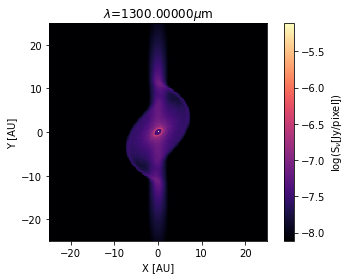

{'implot': <matplotlib.image.AxesImage at 0x7fec48f6ac10>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7fec48f9b9a0>}

In [37]:
dpc = 140.     # Distance in parsec (for conversion to Jy/pixel in 1.3 mm map)
incl = 45.
phi  = 90.

#
# Make and plot image of full disk at 1.3 mm: thermal dust emission
#
makeImage(npix=400,incl=incl,phi=phi,wav=1.3e3,sizeau=50, setthreads=4)   # This calls radmc3d 
im_mm = readImage()
plt.figure()
plotImage(im_mm,au=True,log=True,maxlog=3,bunit='jy/pixel',dpc=dpc,cmap='magma')

Executing RADMC-3D Command:
radmc3d image npix 200 incl 90.0 sizeau 100 lambda 1.0 phi 45.0 pointau 0.0  0.0  0.0 fluxcons setthreads 4
  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2020 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
                     the RADMC-3D forum:                         
   

 Thread:           3 Photon nr:                86000
 Thread:           1 Photon nr:                87000
 Thread:           2 Photon nr:                88000
 Thread:           0 Photon nr:                89000
 Thread:           1 Photon nr:                90000
 Thread:           0 Photon nr:                91000
 Thread:           0 Photon nr:                92000
 Thread:           1 Photon nr:                93000
 Thread:           3 Photon nr:                94000
 Thread:           1 Photon nr:                95000
 Thread:           3 Photon nr:                96000
 Thread:           0 Photon nr:                97000
 Thread:           0 Photon nr:                98000
 Thread:           1 Photon nr:                99000
 Thread:           2 Photon nr:               100000
 Thread:           3 Photon nr:               101000
 Thread:           3 Photon nr:               102000
 Thread:           2 Photon nr:               103000
 Thread:           2 Photon nr:               

 Thread:           0 Photon nr:               246000
 Thread:           3 Photon nr:               247000
 Thread:           0 Photon nr:               248000
 Thread:           3 Photon nr:               249000
 Thread:           2 Photon nr:               250000
 Thread:           2 Photon nr:               251000
 Thread:           3 Photon nr:               252000
 Thread:           3 Photon nr:               253000
 Thread:           0 Photon nr:               254000
 Thread:           3 Photon nr:               255000
 Thread:           0 Photon nr:               256000
 Thread:           1 Photon nr:               257000
 Thread:           0 Photon nr:               258000
 Thread:           1 Photon nr:               259000
 Thread:           1 Photon nr:               260000
 Thread:           0 Photon nr:               261000
 Thread:           2 Photon nr:               262000
 Thread:           0 Photon nr:               263000
 Thread:           2 Photon nr:               

 Thread:           1 Photon nr:               406000
 Thread:           3 Photon nr:               407000
 Thread:           2 Photon nr:               408000
 Thread:           1 Photon nr:               409000
 Thread:           0 Photon nr:               410000
 Thread:           0 Photon nr:               411000
 Thread:           3 Photon nr:               412000
 Thread:           2 Photon nr:               413000
 Thread:           2 Photon nr:               414000
 Thread:           3 Photon nr:               415000
 Thread:           2 Photon nr:               416000
 Thread:           2 Photon nr:               417000
 Thread:           3 Photon nr:               418000
 Thread:           2 Photon nr:               419000
 Thread:           0 Photon nr:               420000
 Thread:           1 Photon nr:               421000
 Thread:           1 Photon nr:               422000
 Thread:           1 Photon nr:               423000
 Thread:           1 Photon nr:               

 Thread:           3 Photon nr:               565000
 Thread:           1 Photon nr:               566000
 Thread:           3 Photon nr:               567000
 Thread:           2 Photon nr:               568000
 Thread:           1 Photon nr:               569000
 Thread:           1 Photon nr:               570000
 Thread:           1 Photon nr:               571000
 Thread:           0 Photon nr:               572000
 Thread:           1 Photon nr:               573000
 Thread:           1 Photon nr:               574000
 Thread:           2 Photon nr:               575000
 Thread:           0 Photon nr:               576000
 Thread:           0 Photon nr:               577000
 Thread:           2 Photon nr:               578000
 Thread:           1 Photon nr:               579000
 Thread:           1 Photon nr:               580000
 Thread:           0 Photon nr:               581000
 Thread:           2 Photon nr:               582000
 Thread:           3 Photon nr:               

 Thread:           3 Photon nr:               721000
 Thread:           0 Photon nr:               722000
 Thread:           1 Photon nr:               723000
 Thread:           0 Photon nr:               724000
 Thread:           2 Photon nr:               725000
 Thread:           0 Photon nr:               726000
 Thread:           2 Photon nr:               727000
 Thread:           0 Photon nr:               728000
 Thread:           1 Photon nr:               729000
 Thread:           1 Photon nr:               730000
 Thread:           2 Photon nr:               731000
 Thread:           0 Photon nr:               732000
 Thread:           2 Photon nr:               733000
 Thread:           3 Photon nr:               734000
 Thread:           2 Photon nr:               735000
 Thread:           2 Photon nr:               736000
 Thread:           3 Photon nr:               737000
 Thread:           1 Photon nr:               738000
 Thread:           1 Photon nr:               

 Thread:           3 Photon nr:               877000
 Thread:           1 Photon nr:               878000
 Thread:           1 Photon nr:               879000
 Thread:           1 Photon nr:               880000
 Thread:           1 Photon nr:               881000
 Thread:           1 Photon nr:               882000
 Thread:           2 Photon nr:               883000
 Thread:           1 Photon nr:               884000
 Thread:           0 Photon nr:               885000
 Thread:           3 Photon nr:               886000
 Thread:           3 Photon nr:               887000
 Thread:           0 Photon nr:               888000
 Thread:           0 Photon nr:               889000
 Thread:           3 Photon nr:               890000
 Thread:           2 Photon nr:               891000
 Thread:           2 Photon nr:               892000
 Thread:           0 Photon nr:               893000
 Thread:           2 Photon nr:               894000
 Thread:           0 Photon nr:               

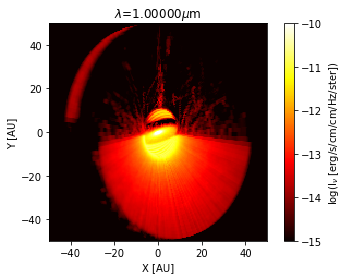

Text(-90, 80, 'With isotropic scattering')

In [14]:
#
# Make and plot image of full disk at 1 microns: scattered light
# and show the difference with and without scattering
#
makeImage(npix=200,incl=incl,phi=phi,wav=1.,sizeau=100, setthreads=4)   # This calls radmc3d 
im_1 = readImage()
plt.figure()
plotImage(im_1,au=True,log=True,vmax=-10,vmin=-15,bunit='inu',cmap='hot')
plt.text(-90,80,'With isotropic scattering',color='white')